# Epoch8.co - SQL

Здравствуйте!

Представляю вам решение тестового задания. При решении первого и второго заданий был использован диалект SQLite, при решении третьего - диалект MS SQL.

**Оглавление:**
1. [inner / left](#task_1)


2. [Лучший ученик](#task_2)
    - [Шаг 1 - исходные данные](#task_2_1)
    - [Шаг 2 - формирование метрики "лучший"](#task_2_2)
    - [Шаг 3 - ранжирование](#task_2_3)
    - [Шаг 4 - вывод результатов](#task_2_4)


3. [Онлайн-кассы](#task_3)
    - [1. Выведите количество активных подписок для каждого приложения с ID и наименованием приложения и ID и описанием категории.](#task_3_1)
    - [2. Выведите количество пользователей, количество и сумму платежей по тем подпискам, которые были отменены в разрезе тарифов.](#task_3_2)
    - [3. Выведите top-10 приложений по убыванию оборота по приложению.](#task_3_3)
    - [4. Выведите top-3 приложений в каждой категории по убыванию оборота по приложению.](#task_3_4)

## 1. inner / left <a id='task_1'></a>

### Задание

Есть две таблицы, в каждой только одна колонка <code>id</code>:

    A
    id
    ---
    1
    2

    B
    id
    ---
    1
    3

Что вернут запросы?

<code>SELECT * FROM A JOIN B ON A.id = B.id;</code>

<code>SELECT * FROM A LEFT JOIN B ON A.id = B.id;</code>

### Решение

В первом случае запрос <code>SELECT * FROM A JOIN B ON A.id = B.id;</code> сформирует таблицу состоящую из записей таблицы <code>A</code> и записей таблицы <code>B</code>. При этом записи будут сопоставлены в соответствии с предикатом <code>A.id = B.id</code>. Так как рядом с оператором <code>JOIN</code> не указан тип соединения, то в соответствии с регулярным выражением этого оператора будет использован тип <code>INNER</code>. При данном типе соединения все строки, которые не удовлетворяют условию <code>ON</code>, будут отброшены, как представлено на следующем изображении.
***
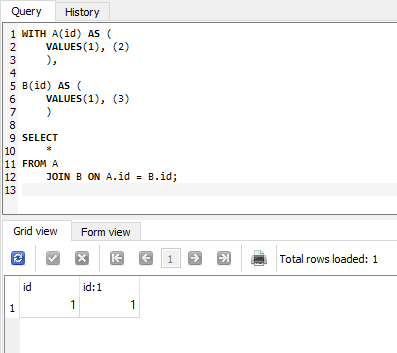
***
Второй запрос <code>SELECT * FROM A LEFT JOIN B ON A.id = B.id;</code> использует тип соединения таблиц <code>LEFT</code>, при котором все строки основной запрашиваемой таблицы <code>A</code> будут сохранены. При этом записи, для которых в результате выполнения предиката <code>A.id = B.id</code> не удалось установить соответствующие записи из таблицы <code>B</code>, частично не будут содержать значения. Такие поля будут заполнены специальным маркером <code>NULL</code>, свидетельствующем о том, что значение не существует.
***
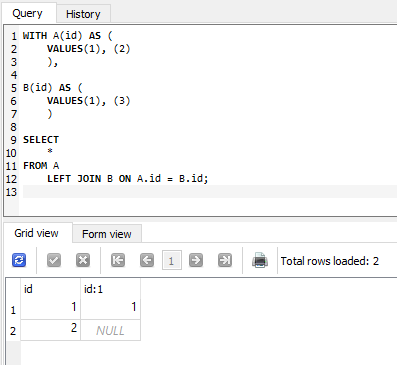

## 2. Лучший ученик <a id='task_2'></a>

### Задание

Есть таблица с оценками учеников:

    Grades
    ----------
    student_id - идентификатор ученика
    subject_id - идентификатор предмета
    grade      - оценка ученика по предмету

Напишите запрос, который для каждого предмета возвращает идентификатор лучшего ученика.

### Решение

Данное задание может быть выполнено с применением оконных функций и CTE.

    WITH t1 AS (
        SELECT
            g.subject_id,
            g.student_id,
            AVG(g.grade) AS grade_avg
        FROM
            Grades AS g
        GROUP BY
            g.subject_id,
            g.student_id
    ),
    
    t2 AS (
        SELECT
            t1.subject_id,
            t1.student_id,
            DENSE_RANK() OVER(PARTITION BY t1.subject_id ORDER BY t1.grade_avg DESC) AS position
        FROM
            t1
    )
    
    SELECT
        t2.subject_id,
        t2.student_id
    FROM
        t2
    WHERE
        t2.position = 1;

**Шаг 1 - исходные данные** <a id='task_2_1'></a>

В процессе решения задач бизнес-логики для отладки запросов могут использоваться срезы баз данных для проверки правильности выполнения запросов и времени их исполнения.

Так и для решения данной задачи были смоделированы исходные данные, как показано на изображении ниже.
***
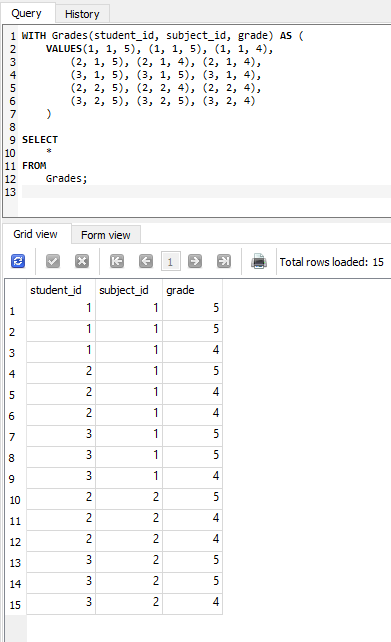
***
Для отладки запроса в таблице "Grades" представлены данные для двух предметов и трёх учеников. Причём для предмета с идентификатором <code>1</code> будут сразу два лучших ученика. Это важный момент который будет учтён далее.

**Шаг 2 - формирование метрики "лучший"** <a id='task_2_2'></a>

Для ранжирования учеников в рамках каждого предмета будем использовать метрику "средний балл успеваемости".
***
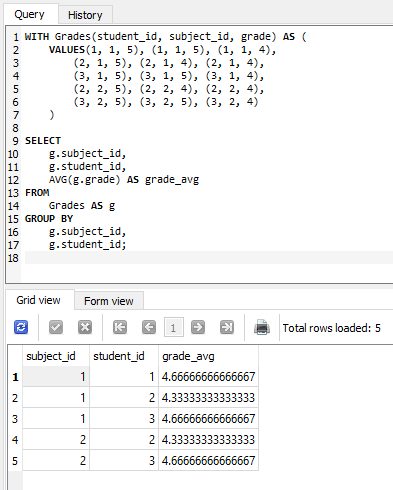
***
Для каждой пары "идентификатор ученика" и "идентификатор предмета" с группировкой было вычислено среднее значение столбца "grade", что отражает вышеупомянутую метрику.

**Шаг 3 - ранжирование** <a id='task_2_3'></a>

Теперь необходимо на основании метрики <code>grade_avg</code> необходимо ранжировать учеников чтобы определить лучших.

Как было упомянуто в *Шаге 1*, для одного предмета может быть несколько лучших учеников. Если использовать функцию <code>ROW_NUMBER()</code> для ранжирования, то будет выбран только один лучший ученик.
***
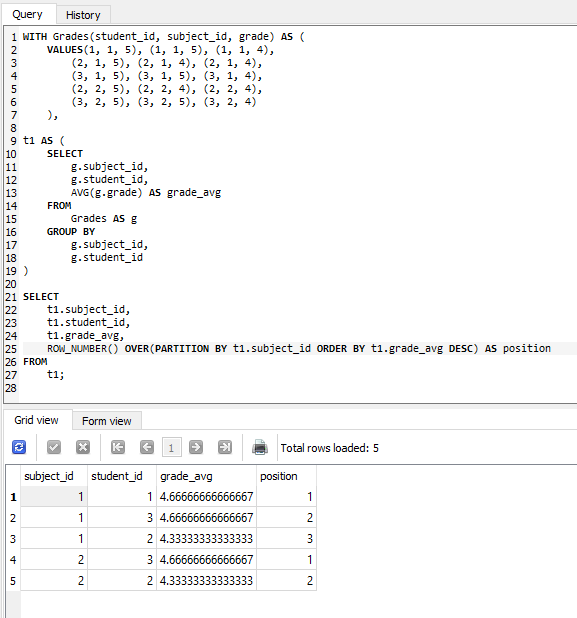
***
В данном случае получилось, что для предмета <code>1</code> ученики <code>1</code> и <code>3</code> имеют одинаковые значения метрики, однако только один из учеников будет лучшим.

На мой взгляд, решение задачи данным образом некорректно, так как результат необъективен и более того, содержит неявный элемент случайности выбора лучшего ученика среди учеников с наивысшими метриками.

Поэтому для решения задачи я использовал функцию <code>DENSE_RANK()</code>.
***
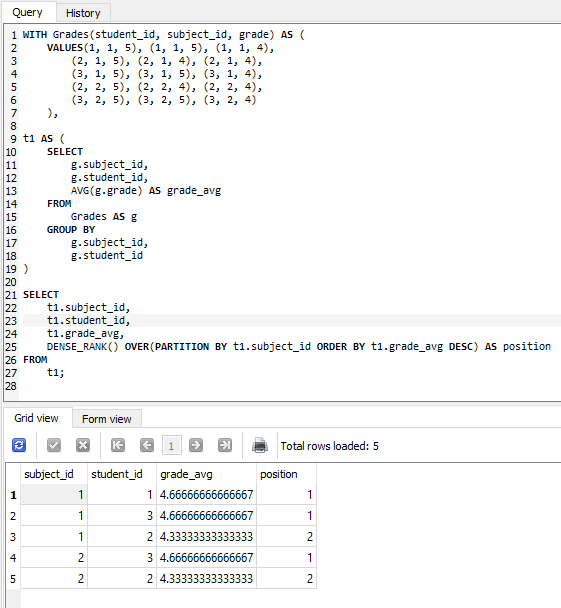
***
Функция <code>DENSE_RANK()</code> позволила определить всех лучших учеников для каждого предмета.

**Шаг 4 - вывод результатов** <a id='task_2_4'></a>

Применив ранжирование, были получены позиции учеников в зависимости от их среднего балла в рамках каждого предмета. Теперь необходимо выбрать лидеров.
***
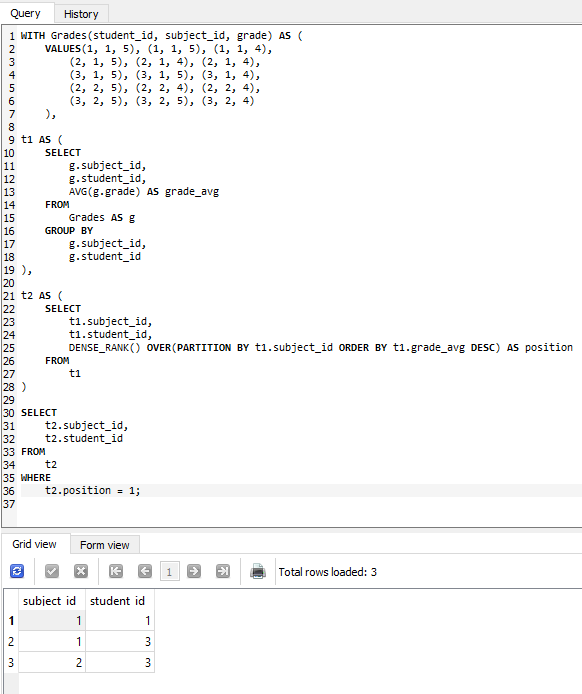
***
В результате выполнения запроса для предмета <code>2</code> был отображён единственный лучший ученик, а для предмета <code>1</code> - двое лучших.

Данный подход к решению задачи позволит отразить факт, что качеству "лучший" соответствуют сразу несколько учеников и предоставить дальнейший выбор пользователю. Также данное решение исключает неявный фактор случайности, когда при равных метриках выбор лучшего ученика мог происходить из-за скрытых особенностей конкретного диалекта SQL.

## 3. Онлайн-кассы <a id='task_3'></a>

### Задание

***
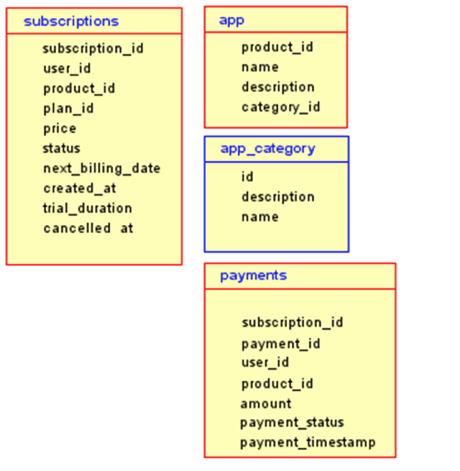
***
1. Выведите количество активных подписок для каждого приложения с ID и наименованием приложения и ID и описанием категории.
2. Выведите количество пользователей, количество и сумму платежей по тем подпискам, которые были отменены в разрезе тарифов.
3. Выведите top-10 приложений по убыванию оборота по приложению.
4. Выведите top-3 приложений в каждой категории по убыванию оборота по приложению.

### Решение

#### 1. Выведите количество активных подписок для каждого приложения с ID и наименованием приложения и ID и описанием категории. <a id='task_3_1'></a>

Из предположения, что если поле <code>cancelled_at</code> в таблице <code>subscriptions</code> имеет значение <code>NULL</code>, то подписка не отменена, то есть является активной. 

    -- CTE для формирования количества подписок для каждого приложения.
    WITH t1 AS (
        SELECT
            s.product_id,
            COUNT(*) AS cnt
        FROM
            subscriptions AS s
        WHERE
            s.cancelled_at IS NULL
        GROUP BY
            s.product_id
    )
    
    SELECT
        a.name,
        ap.description,
        COALESCE(t1.cnt, 0) AS cnt
    FROM
        app AS a
        INNER JOIN app_category AS ap ON ap.id = a.id_category_id
        LEFT JOIN t1 ON t1.product_id = a.product_id

Интересной особенностью здесь является то, что некоторые приложения могут не иметь активных подписок. Чтобы они присутствовали в результирующей таблице, сперва происходит выбор всех приложений из таблицы <code>app</code>, затем каждому приложению сопоставляется количество его подписок из CTE <code>t1</code>. Если приложение не имеет подписок, то значение <code>NULL</code> будет преобразовано в 0 при помощи функции <code>COALESCE()</code>.

#### 2. Выведите количество пользователей, количество и сумму платежей по тем подпискам, которые были отменены в разрезе тарифов. <a id='task_3_2'></a>

Не очень понимаю здесь значение фразы "в разрезе тарифов".

    -- CTE для формирования списка отменённых подписок.
    WITH t1 AS (
        SELECT
            s.subscription_id
        FROM
            subscriptions AS s
        WHERE
            s.cancelled_at IS NOT NULL
    )
    
    SELECT
        COUNT(DISTINCT p.user_id) AS user_count,
        COUNT(p.payment_id) AS payment_count
        SUM(p.amount) AS payment_amount
    FROM
        payments AS p
    WHERE
        p.subscription_id IN (SELECT t1.subscription_id FROM t1)
    GROUP BY
        p.user_id
        
Сперва в CTE формируется список отменённых подписок. Затем из таблицы <code>payments</code> выбираются те записи, которые есть в списке отменённых подписок. После этого выполняются финальные расчёты. если конструкция <code>COUNT(DISTINCT p.user_id)</code> не сработает в конкретном диалекте SQL, то её можно заменить дополнительными CTE:

    -- CTE для формирования списка отменённых подписок.
    WITH t1 AS (
        SELECT
            s.subscription_id
        FROM
            subscriptions AS s
        WHERE
            s.cancelled_at IS NOT NULL
    )

    -- CTE для формирования списка уникальных пользователей отменённых подписок.
    t2 AS (
        SELECT DISTINCT
            p.user_id
        FROM
            payments AS p
        WHERE
            p.subscription_id IN (SELECT t1.subscription_id FROM t1)
    ),
    
    SELECT
        (SELECT COUNT(*) FROM t2) AS user_count,
        COUNT(p.payment_id) AS payment_count
        SUM(p.amount) AS payment_amount
    FROM
        payments AS p
    WHERE
        p.subscription_id IN (SELECT t1.subscription_id FROM t1)
    GROUP BY
        p.user_id

Предполагаю, что в целях оптимизации конструкцию <code>p.subscription_id IN (SELECT t1.subscription_id FROM t1)</code> можно было бы заменить на некий аналог <code>CROSS APPLY</code>.

#### 3. Выведите top-10 приложений по убыванию оборота по приложению. <a id='task_3_3'></a>

    -- CTE для формирования суммы платежей для каждой подписки.
    WITH t1 AS (
        SELECT
            p.subscription_id
            SUM(p.amount) AS amount_subscription
        FROM
            payments AS p
        GROUP BY
            p.subscription_id
    ),
    
    -- CTE для формирования суммы оборота для каждого приложения.
    t2 AS (
        SELECT
            s.product_id,
            SUM(t1.amount_subscription) AS amount_product
        FROM
            subscriptions AS s
            INNER JOIN t1 ON t1.subscription_id = s.subscription_id
        GROUP BY
            s.product_id
    ),
    
    -- CTE для выбора всех приложений и сопоставления оборота.
    t3 AS (
        SELECT
            a.name,
            COALESCE(t2.amount_product, 0) AS amount_product
        FROM
            app AS a
            LEFT JOIN t2 ON t2.product_id = a.product_id
    )
    
    -- Выбор первых десяти приложений по убыванию оборота.
    SELECT TOP 10
        t3.name,
        t3.amount_product
    FROM
        t3
    ORDER BY
        t3.amount_product DESC

В целях оптимизации нагрузки на сервер, сперва вычисляется сумма платежей для каждой подписки. Затем вычисляется сумма оборота для каждого приложения. Потом используется список всех приложений для формирования топ 10 по убыванию оборота.

#### 4. Выведите top-3 приложений в каждой категории по убыванию оборота по приложению. <a id='task_3_4'></a>

    -- CTE для формирования суммы платежей для каждой подписки.
    WITH t1 AS (
        SELECT
            p.subscription_id
            SUM(p.amount) AS amount_subscription
        FROM
            payments AS p
        GROUP BY
            p.subscription_id
    ),
    
    -- CTE для формирования суммы оборота для каждого приложения.
    t2 AS (
        SELECT
            s.product_id,
            SUM(t1.amount_subscription) AS amount_product
        FROM
            subscriptions AS s
            INNER JOIN t1 ON t1.subscription_id = s.subscription_id
        GROUP BY
            s.product_id
    ),
    
    -- CTE для выбора всех приложений и сопоставления оборота и категории.
    t3 AS (
        SELECT
            a.name,
            ap.name AS name_category,
            COALESCE(t2.amount_product, 0) AS amount_product
        FROM
            app AS a
            INNER JOIN app_category AS ap ON ap.id = a.category_id
            LEFT JOIN t2 ON t2.product_id = a.product_id
    ),
    
    -- CTE для ранжирования приложений по убыванию оборота внутри каждой категории.
    t4 AS (
        SELECT TOP 10
            t3.name,
            t3.name_category,
            t3.amount_product,
            ROW_NUMBER() OVER(PARTITION BY t3.name_category ORDER BY t3.amount_product DESC) AS rn
        FROM
            t3
    )
    
    -- Выбор топ-3 приложений по обороту для каждой категории.
    SELECT
        t4.name,
        t4.name_category,
        t4.amount_product
    FROM
        t4
    WHERE
        t4.rn < 3

Для решения задания были использованы наработки предыдущего задания. Отличия заключаются в следующем:
 - в CTE <code>t3</code> было добавлено поле <code>name_category</code>;
 - в CTE <code>t4</code> было проведено ранжирование приложений внутри каждой категории;
 - в основном запросе были выбраны приложения из топ-3 по убыванию оборота внутри каждой категории.